# CmdStanPy Tutorial


### Workflow Outline

Given a dataset and a model specification written as a Stan program, the CmdStanPy workflow is:

#### Assemble input data as either:
  + a Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + an existing data file on disk in either JSON or Rdump format.
  + CmdStanPy provides methods for converting former to latter.




#### Compile Stan program - function `compile_model`
  + takes as input a Stan program and produces the corresponding c++ executable.
  + both Stan program and c++ executable exist as on-disk files

#### Assemble input data as either:
  + a Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + an existing data file on disk in either JSON or Rdump format.

#### Run sampler - function `sample`
  + invokes Stan's NUTS-HMC sampler to condition model on input data, produces output csv files
  + runs any number of chains - should run at least 2 (default)
  + lightweight object `RunSet` keeps track of sampler arguments, per-chain outcome, output files
  + returns `PosteriorSample` object which contains information about sample

#### Analyze resulting `PosteriorSample`
  + `PosteriorSample` contains names of csv output files, names of csv column headers
  + methods `summary` and `diagnose` invoke CmdStan tools `bin/stansummary` and `bin/diagnose` respectively
  + `sample` property holds the in-memory sample
  + `stepsize` property holds the stepsize used by sampler for each chain
  + `metric` property holds the metric used by sampler for each chain

### Installation

* Clone or download CmdStanPy from GitHub repository https://github.com/stan-dev/cmdstanpy

* CmdStanPy uses CmdStan directly to compile and run Stan programs, therefore CmdStan must be installed locally.

  + if you have a working installation of CmdStan, set environment variable `CMDSTAN` to the full path to the top-level CmdStan directory.
  
  + if you don't already have CmdStan installed, run script `make_cmdstan.sh` which downloads and compiles the latest release from https://github.com/stan-dev/cmdstan/releases.  By default this installs the latest version of CmdStan in the location `~/.cmdstanpy`.  Flags -d and -v are used to specify the directory and version, respectively.


### Example 1:  example model `bernoulli.stan`, data `bernoulli.data.json`

Import relevant classes and methods


In [1]:
import os
import os.path
from cmdstanpy.lib import Model, PosteriorSample
from cmdstanpy.cmds import compile_model, sample

The CmdStanPy directory `test/data` contains models

In [2]:
datafiles_path = os.path.expanduser(
    os.path.join("~", "github", "stan-dev", "cmdstanpy", "test", "data"))
stan = os.path.join(datafiles_path, "bernoulli.stan")

Call `compile_model` with path to Stan program, returns `Model` object `bernoulli_model`

In [3]:
bernoulli_model = compile_model(stan)
print(bernoulli_model)

Model(name=bernoulli,  stan_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/data/bernoulli.stan", exe_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/data/bernoulli")


Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.  If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [4]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

Call `sample` to run NUTS-HMC sampler, returns `PosteriorSample` object `a_sample`

In [5]:
a_sample = sample(bernoulli_model, chains=4, cores=2, data=bern_data)

input data tempfile: /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmp546biv20/tmpktez1i7q.json
start chain 1.  start chain 2.  

finish chain 1.  
start chain 3.  
finish chain 2.  
start chain 4.  
finish chain 3.  
finish chain 4.  


In [6]:
print(a_sample)

PosteriorSample(chains=4,  draws=1000, columns=8)


### `PosteriorSample` object functions and attributes

#### PosteriorSample.summary()

The `summary` function returns output of CmdStan bin/stansummary as pandas.DataFrame:

In [7]:
a_sample.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.251000,0.01974,0.705775,-8.749310,-6.97809,-6.749950,1278.29,5581.30,1.00199
theta,0.246911,0.00306,0.115661,0.077695,0.23484,0.451042,1428.82,6238.56,1.00078


#### PosteriorSample.diagnose()

The `diagnose` function prints diagnostics to console:

In [8]:
a_sample.diagnose()

No problems detected.


#### PosteriorSample.extract()

The `extract` function returns a pandas.DataFrame, one draw per row.  It contains all columns from the sampler's csv output file, i.e., it contains both the sampler state and the values for all parameter, transformed parameter, and generated quantities variables.

In [9]:
samp = a_sample.extract()
samp.shape, samp.columns

((4000, 8),
 Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'))

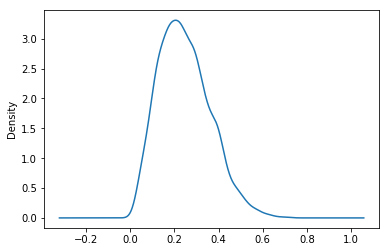

In [11]:
samp.theta.plot.density()

The `extract` function argument `params` takes a list of parameter or column names:

In [12]:
thetas = a_sample.extract(params=['theta'])
thetas.shape


(4000, 1)

In [13]:
thetas[0:3]

,theta
0,0.343484
1,0.232548
2,0.342342


#### PosteriorSample.sample

The `sample` property is a 3-D numpy ndarray which contains all draws across all chains.  This array is created only as needed; therefore the first time that this property is accessed CmdStanPy will read in the contents of the sampler's csv output files.  Because the csv output files also contain stepsize and metric information, the `stepsize` and `metric` arrays will also be created.

The ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns):

In [14]:
a_sample.sample
a_sample.sample.shape

(1000, 4, 8)

In [15]:
a_sample.column_names[7], a_sample.sample[0:3,0,7]

('theta', array([0.343484, 0.232548, 0.342342]))

#### PosteriorSample.stepsize

The `stepsize` property is a 1-D numpy ndarray which contains the stepsize used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the stepsize for the 4 chains in this example is:

In [16]:
a_sample.stepsize

array([0.850374, 0.789576, 0.826539, 1.10651 ])

#### PosteriorSample.metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `stepsize` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [17]:
a_sample.metric

array([[0.507758],
       [0.42248 ],
       [0.528419],
       [0.422747]])